In [8]:
import sys
import numpy as np
import netCDF4 as nc
import xarray as xr
import ast
import pandas as pd
import glob
import numpy.ma as ma
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
coastline = cfeature.GSHHSFeature(scale='full',levels=[1]) 
import warnings
warnings.simplefilter('ignore')
ds_path = '/Users/opticslab/Documents/BIOSCAPE/MSI/level2/'



In [9]:

# NEW coastal MSI MLR ag300
c1 = 0.11846254; c2 =  -0.22682844; c3 =  -0.49286301; c4 =   0.95386257; c5 = 3.521790406144991


#New costal + inland s275
d1 = -5.23499640e-02; d2 = 2.13194898e-01; d3 = -2.54044384e-05; d4 = -2.21348532e-01; d5 =-4.402270165120944


# sentinel 2 MSI bands (polymer outputs Rw, double check for other ACs used)
bands = ['Rw443', 'Rw490', 'Rw560', 'Rw665', 'Rw705', 'Rw740', 'Rw783']
rrs_bands = ['Rrs_443', 'Rrs_490', 'Rrs_560', 'Rrs_665', 'Rrs_705', 'Rrs_740', 'Rrs_783']

# orginzation preprocess xarray from Jonathan, modified for sentinel 2 from 3 (see height/width dimensions(Booo))
def preprocess(ds):        # tunr Rw to Rrs and format for later use
    ds_new =  xr.Dataset(
        {'Rrs_443': xr.DataArray(
            data = ds.variables[bands[0]] / np.pi, dims=['height', 'width'], coords={'Date':pd.to_datetime(ds.sensing_time.split(' ')[0]), 'lat':ds.variables['latitude'][:], 'lon':ds.variables['longitude'][:]}, attrs  = {'units':'sr^-1'}),
         'Rrs_490': xr.DataArray(
            data = ds.variables[bands[1]] / np.pi, dims=['height', 'width'], coords={'Date':pd.to_datetime(ds.sensing_time.split(' ')[0]), 'lat':ds.variables['latitude'][:], 'lon':ds.variables['longitude'][:]}, attrs  = {'units':'sr^-1'}),
        'Rrs_560': xr.DataArray(
            data = ds.variables[bands[2]] / np.pi, dims=['height', 'width'], coords={'Date':pd.to_datetime(ds.sensing_time.split(' ')[0]), 'lat':ds.variables['latitude'][:], 'lon':ds.variables['longitude'][:]}, attrs  = {'units':'sr^-1'}),
        'Rrs_665': xr.DataArray(
            data = ds.variables[bands[3]] / np.pi, dims=['height', 'width'], coords={'Date':pd.to_datetime(ds.sensing_time.split(' ')[0]), 'lat':ds.variables['latitude'][:], 'lon':ds.variables['longitude'][:]}, attrs  = {'units':'sr^-1'}),
        'Rrs_705': xr.DataArray(
            data = ds.variables[bands[4]] / np.pi, dims=['height', 'width'], coords={'Date':pd.to_datetime(ds.sensing_time.split(' ')[0]), 'lat':ds.variables['latitude'][:], 'lon':ds.variables['longitude'][:]}, attrs  = {'units':'sr^-1'}),
        'Rrs_740': xr.DataArray(
            data = ds.variables[bands[5]] / np.pi, dims=['height', 'width'], coords={'Date':pd.to_datetime(ds.sensing_time.split(' ')[0]), 'lat':ds.variables['latitude'][:], 'lon':ds.variables['longitude'][:]}, attrs  = {'units':'sr^-1'}),
         'Rrs_783': xr.DataArray(
            data = ds.variables[bands[6]] / np.pi, dims=['height', 'width'], coords={'Date':pd.to_datetime(ds.sensing_time.split(' ')[0]), 'lat':ds.variables['latitude'][:], 'lon':ds.variables['longitude'][:]}, attrs  = {'units':'sr^-1'})})   
    
    ds_new = ds_new.pad({'height': ((0, 1001 - len(ds_new['height'])))},mode='constant',constant_values=np.nan)
    ds_new = ds_new.pad({'width': ((0, 1001 - len(ds_new['width'])))},mode='constant',constant_values=np.nan)
    
    
    return ds_new

def cdom_calc(rrs_443, rrs_490, rrs_560, rrs_665):
    ag300 = np.exp(c1 * np.log(rrs_443) + c2 * np.log(rrs_490) +
                      c3 * np.log(rrs_560) + c4 * np.log(rrs_665) +
                      c5 )
    return ag300

def s275_calc(rrs_443, rrs_490, rrs_560, rrs_665):
    s275 = np.exp(d1 * np.log(rrs_443) + d2 * np.log(rrs_490) +
                      d3 * np.log(rrs_560) + d4 * np.log(rrs_665) +
                      d5 )
    return s275

flist = sorted(glob.glob(f'{ds_path}/*'))

olci = xr.open_mfdataset(flist,  preprocess=preprocess,combine='nested', concat_dim='Date') #,concat_dim=['Date', None, None]


bands = ['Rrs_443', 'Rrs_490', 'Rrs_560', 'Rrs_665']

olci[bands] = olci[bands].where(olci[bands]>0)


olci = olci.assign(cdom=lambda olci: cdom_calc(olci.Rrs_443, olci.Rrs_490, olci.Rrs_560, olci.Rrs_665))
olci = olci.assign(s275=lambda olci: s275_calc(olci.Rrs_443, olci.Rrs_490, olci.Rrs_560, olci.Rrs_665))


olci = olci.sortby('Date')

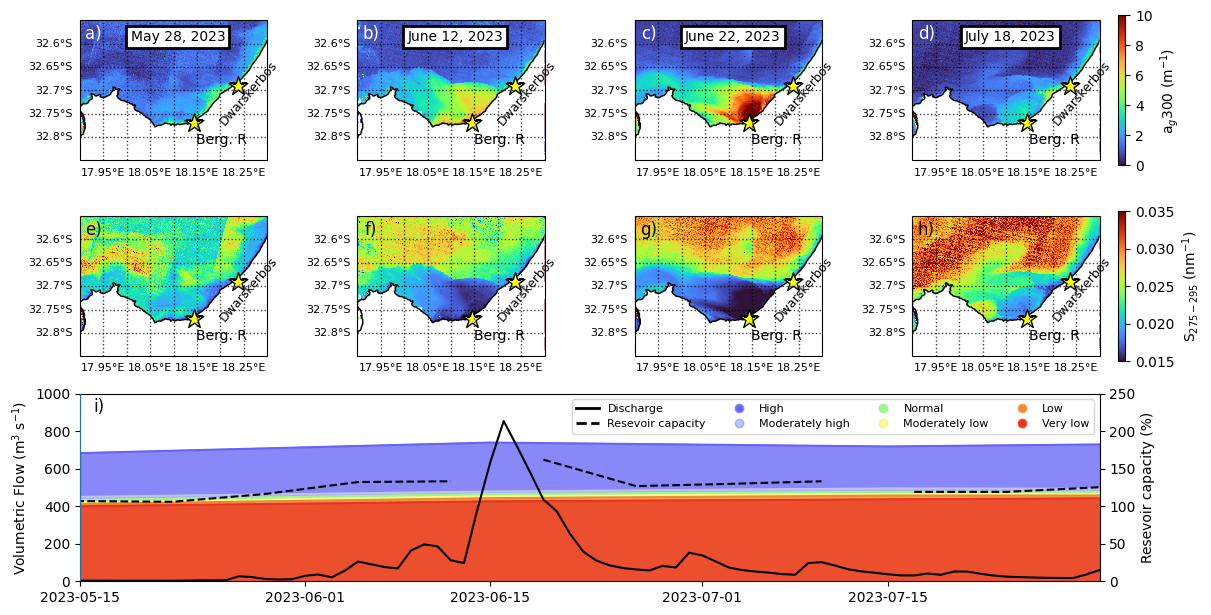

In [11]:



misv_dam = pd.read_csv('/Users/opticslab/Documents/BIOSCAPE/spreadsheets/Surface Water Storage ( Misverstand Dam )-Latest data as at_ 04-Aug-2024.csv')
berg_river = pd.read_csv('/Users/opticslab/Documents/BIOSCAPE/spreadsheets/verified---river-flow-(-g1h013_-berg-@-drieheuvels-)_5yr.csv')
berg_river['monitoring_period'] = pd.to_datetime(berg_river['monitoring_period'])
berg_precip = pd.read_csv('/Users/opticslab/Documents/BIOSCAPE/spreadsheets/Rainfall.csv')
berg_precip['RNFL_DATE'] = pd.to_datetime(berg_precip['RNFL_DATE'])

misv_dam['DateTime'] = pd.to_datetime(misv_dam['DateTime'])
perc_misv = ~np.isnan(misv_dam['High'])



fig = plt.figure(figsize=(12,9),layout = "compressed")
gs = GridSpec(3, 4, figure=fig, wspace = 0)  # 3 rows, 2 columns


dts = ['May 28, 2023','June 12, 2023','June 22, 2023','July 18, 2023']
lets = ['a)','b)','c)','d)','e)','f)','g)','h)']

for i in range(4):
    
    
    ax = fig.add_subplot(gs[0, i],projection=ccrs.PlateCarree())

    ax.set_extent([18.3,17.9, -32.85, -32.55], crs=ccrs.PlateCarree())
    ax.add_feature(coastline, ec=(0,0,0,1),fc=(1,1,1,1))
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                linewidth=1, color='k', alpha=0.75, linestyle=':')

    gl.top_labels=False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

    vmin = 0
    vmax = 10
    cs1 = ax.pcolor(olci.lon, olci.lat, olci.cdom[i], cmap='turbo', vmin=vmin, vmax=vmax)
    ax.scatter(18.144105,-32.769624,  s=200, marker = '*', cmap='turbo',edgecolors = 'black', color = 'yellow',zorder=2)
    ax.annotate('Berg. R', (18.144105,-32.769624), textcoords="offset points", xytext=(20,-15), ha='center',color = 'black', fontsize = 10)
    ax.annotate(dts[i], (18.05,-32.55), textcoords="offset points", bbox=dict(boxstyle="square",pad=0.3,
                     fc="white", ec="black", lw=2), xytext=(20,-15), ha='center',color = 'black', fontsize = 10)
   
    ax.scatter(18.237731,-32.690843,  s=200, marker = '*', cmap='turbo',edgecolors = 'black', color = 'yellow',zorder=2)
    ax.annotate('Dwarskerbos', (18.237731,-32.690843), rotation = 49, textcoords="offset points", xytext=(8,-28), ha='center',color = 'black', fontsize = 9)
    
    
    
    ax1 = fig.add_subplot(gs[1, i],projection=ccrs.PlateCarree())

    ax1.set_extent([18.3,17.9, -32.85, -32.55], crs=ccrs.PlateCarree())
    ax1.add_feature(coastline, ec=(0,0,0,1),fc=(1,1,1,1))
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                linewidth=1, color='k', alpha=0.75, linestyle=':')

    gl.top_labels=False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

    vmin = 0.015
    vmax = 0.035
    cs2 = ax1.pcolor(olci.lon, olci.lat, olci.s275[i], cmap='turbo', vmin=vmin, vmax=vmax)
    ax1.scatter(18.144105,-32.769624,  s=200, marker = '*', cmap='turbo',edgecolors = 'black', color = 'yellow',zorder=2)
    ax1.annotate('Berg. R', (18.144105,-32.769624), textcoords="offset points", xytext=(20,-15), ha='center',color = 'black', fontsize = 10)
    
    
    
    ax1.scatter(18.237731,-32.690843,  s=200, marker = '*', cmap='turbo',edgecolors = 'black', color = 'yellow',zorder=2)
    ax1.annotate('Dwarskerbos', (18.237731,-32.690843), rotation = 49, textcoords="offset points", xytext=(8,-28), ha='center',color = 'black', fontsize = 9)
    
    
    ax.annotate(lets[i], (17.87,-32.545), textcoords="offset points", xytext=(20,-15), ha='center',color = 'w', fontsize = 12)
    ax1.annotate(lets[i+4], (17.87,-32.545), textcoords="offset points", xytext=(20,-15), ha='center',color = 'black', fontsize = 12)
    

    
    if i == 3:
        
        
        cbar = fig.colorbar(cs1, orientation="vertical", pad = -0.2, shrink=0.8)
        cbar.set_label('a$_{g}$300 (m$^{-1}$)', fontsize=10)


        cbar = fig.colorbar(cs2, orientation="vertical", pad = -0.2, shrink=0.8)
        cbar.set_label('S$_{275-295}$ (nm$^{-1}$)', fontsize=10)
        
        
       
ax2 = fig.add_subplot(gs[2, :])
ax2t = ax2.twinx()


ax2t.plot(misv_dam['DateTime'][perc_misv],misv_dam['High'][perc_misv],color = '#6464F6')
ax2t.fill_between(misv_dam['DateTime'][perc_misv],misv_dam['High'][perc_misv],color = '#8888F8')

ax2t.plot(misv_dam['DateTime'][perc_misv],misv_dam['Moderately_High'][perc_misv],color = '#C0C0FA')
ax2t.fill_between(misv_dam['DateTime'][perc_misv],misv_dam['Moderately_High'][perc_misv],color = '#ACACF1')

ax2t.plot(misv_dam['DateTime'][perc_misv],misv_dam['Normal'][perc_misv],color = '#9EF78C')
ax2t.fill_between(misv_dam['DateTime'][perc_misv],misv_dam['Normal'][perc_misv],color = '#9EF78C')

ax2t.plot(misv_dam['DateTime'][perc_misv],misv_dam['Moderately_Low'][perc_misv],color = '#FCFC90')
ax2t.fill_between(misv_dam['DateTime'][perc_misv],misv_dam['Moderately_Low'][perc_misv],color = '#E8FA98')

ax2t.plot(misv_dam['DateTime'][perc_misv],misv_dam['Low'][perc_misv],color = '#EF8733')
ax2t.fill_between(misv_dam['DateTime'][perc_misv],misv_dam['Low'][perc_misv],color = '#EDA44C')

ax2t.plot(misv_dam['DateTime'][perc_misv],misv_dam['Very_Low'][perc_misv],color = '#EA3323')
ax2t.fill_between(misv_dam['DateTime'][perc_misv],misv_dam['Very_Low'][perc_misv],color = '#EB4F2E')


ax2t.plot(misv_dam['DateTime'],misv_dam['rescap2324'],'--k')
ax2t.set_xlim([datetime.date(2023, 5, 15), datetime.date(2023, 7, 31)])
ax2t.set_ylabel('Resevoir capacity (%)')
ax2t.set_ylim([0, 250])


ax2.plot(berg_river['monitoring_period'],berg_river['River_Flow'],color = 'k')
ax2.set_ylabel('Volumetric Flow (m$^{3}$ s$^{-1}$)')


ax2.set_ylim([0, 1000])

ax2.axvline(x = datetime.date(2023, 5, 15))
ax2.set_zorder(ax2.get_zorder()+1)
ax2.set_frame_on(False)

legend_elements = [Line2D([0], [0], color='k', lw=2, label='Discharge'),
                   Line2D([0], [0], color='k',linestyle='--', lw=2, label='Resevoir capacity'),
                   Line2D([0], [0], marker='o', markerfacecolor='#6464F6', markeredgecolor='#8888F8',linestyle = 'None', label='High'),
                   Line2D([0], [0], marker='o', markerfacecolor='#C0C0FA', markeredgecolor='#ACACF1',linestyle = 'None', label='Moderately high'),
                   Line2D([0], [0], marker='o', markerfacecolor='#9EF78C', markeredgecolor='#9EF78C',linestyle = 'None', label='Normal'),
                   Line2D([0], [0], marker='o', markerfacecolor='#FCFC90', markeredgecolor='#E8FA98',linestyle = 'None', label='Moderately low'),
                   Line2D([0], [0], marker='o', markerfacecolor='#EF8733', markeredgecolor='#EDA44C',linestyle = 'None', label='Low'),
                   Line2D([0], [0], marker='o', markerfacecolor='#EA3323', markeredgecolor='#EB4F2E',linestyle = 'None', label='Very low')]


ax2.legend(handles=legend_elements, loc='upper right', fontsize = "8",ncol=4)
    
ax2.text(datetime.date(2023, 5, 16),905, 'i)', fontsize = 12)

plt.show()


